In [8]:
import time
import sys
import os
import numpy as np
import meshcat.geometry as g
import meshcat.transformations as tf
import pinocchio as pin
from pinocchio.visualize import MeshcatVisualizer
sys.path.append('../src')
sys.path.append('../../../')
from utils import rk4
import torch
import bindings.bsqp_N16 as bsqp
np.set_printoptions(linewidth=99999999)
np.random.seed(42)

class GATO:
    def __init__(self, N=16, dt=0.03125, batch_size=4, stats=None, f_ext_std=1.0):
        self.N = N
        self.dt = dt
        
        solver_map = {
            1: bsqp.BSQP_1,
            16: bsqp.BSQP_16,
            32: bsqp.BSQP_32
        }
        if batch_size not in solver_map:
            raise ValueError(f"Batch size {batch_size} not supported")
        
        self.batch_size = batch_size
        self.solver = solver_map[batch_size](dt, 10, 0.1, 100, 1e-5, 1.0, 1.0, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5)
        
        self.stats = stats or {
            'solve_time': {'values': [], 'unit': 'us', 'multiplier': 1},
            'pcg_iters': {'values': [], 'unit': '', 'multiplier': 1},
            "step_size": {"values": [], "unit": "", "multiplier": 1},
            'sqp_iters': {'values': [], 'unit': '', 'multiplier': 1}
        }
        
        if f_ext_std == 0.0:
            self.f_ext_batch = np.zeros((self.batch_size, 6))
        else:
            self.f_ext_batch = np.random.normal(0, f_ext_std, (self.batch_size, 6))
            self.f_ext_batch[:, 3:] = 0.0
            self.f_ext_batch[0] = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])  
        
        self.solver.set_f_ext_batch(self.f_ext_batch)
        
    def solve(self, xcur_batch, eepos_goals_batch, XU_batch):
        
        result = self.solver.solve(XU_batch, self.dt, xcur_batch, eepos_goals_batch)

        self.stats['solve_time']['values'].append(result["sqp_time_us"])
        self.stats['sqp_iters']['values'].append(result["sqp_iters"])
        self.stats['pcg_iters']['values'].append(result["pcg_iters"])
        self.stats["step_size"]["values"].append(result["ls_step_size"])
        return result["XU"]
    
    def sim_forward(self, xk, uk, sim_dt):
        x_next_batch = self.solver.sim_forward(xk, uk, sim_dt)
        return x_next_batch
        
    def reset_dual(self):
        self.solver.reset_dual()
        
    def get_stats(self):
        return self.stats
    
    

class MPC_GATO:
    def __init__(self, model, N=32, dt=0.03125, batch_size=1, constant_f_ext=None, f_ext_std=0.0, f_ext_resample_std=0.0):
        self.model = model
        self.test_model = model
        self.data = model.createData()
        self.test_data = model.createData()
        self.model.gravity.linear = np.array([0, 0, -9.81])
        
        self.solver = GATO(N, dt, batch_size, f_ext_std=f_ext_std)
        self.xpath = []  # Store trajectory for visualization
        
        self.nq = self.model.nq
        self.nv = self.model.nv
        self.nx = self.nq + self.nv
        self.nu = len(self.model.joints) - 1
        
        if f_ext_resample_std != 0:
            self.resample_f_ext = True
            self.f_ext_resample_std = f_ext_resample_std
        else:
            self.resample_f_ext = False
            self.f_ext_resample_std = 0.0
        
        if constant_f_ext is not None:
            force = pin.Force(constant_f_ext[:3], np.array([0, 0, 0]))
            forces = pin.StdVec_Force()
            for _ in range(self.model.njoints-1):
                forces.append(pin.Force.Zero())
            forces.append(force)
            self.constant_f_ext = forces
            self.actual_f_ext = constant_f_ext
        else:
            self.constant_f_ext = pin.StdVec_Force()
            for _ in range(self.model.njoints):
                self.constant_f_ext.append(pin.Force.Zero())
                
    def run_mpc_fig8(self, xstart, fig8_traj, sim_dt=0.001, sim_time=5):        
        xcur = xstart
        best_id = 0
        u_last = np.zeros(self.nu)
        xcur_batch = np.tile(xstart, (self.solver.batch_size, 1))
        
        eepos_offset = 0
        eepos_goal = fig8_traj[:6*self.solver.N]
        eepos_goal_batch = np.tile(eepos_goal, (self.solver.batch_size, 1))
        
        stats = {
            'solve_times': [],
            'goal_distances': [],
            'control_inputs': []
        }
        
        XU = np.zeros(self.solver.N*(self.nx+self.nu)-self.nu)
        XU[0:self.nx] = xcur # need better initialization
        XU_batch = np.tile(XU, (self.solver.batch_size, 1))
        XU_batch = self.solver.solve(xcur_batch, eepos_goal_batch, XU_batch)
        XU_best = XU_batch[0, :]
        
        time_accumulated = 0.0 
        num_steps = int(sim_time / sim_dt)
        
        print(f"Running MPC with {num_steps} steps, sim_dt: {sim_dt}")
        
        for i in range(num_steps):
            
            self.constant_f_ext = pin.StdVec_Force()
            for _ in range(self.model.njoints-1):
                self.constant_f_ext.append(pin.Force.Zero())
            pin.forwardKinematics(self.model, self.data, xcur[:self.nq])
            pin.updateFramePlacements(self.model, self.data)
            world_force = pin.Force(self.actual_f_ext[:3], np.array([0, 0, 0]))
            self.constant_f_ext.append(world_force) 
            
                
            x_last = xcur
            u_last = XU_best[self.nx:self.nx+self.nu]
            # Simulate forward
            sim_time_step = sim_dt  # hard coded timestep for now, realistically should be trajopt solver time
            sim_steps = 0  # full solver.dt steps completed
            q = xcur[:self.nq]
            v = xcur[self.nq:self.nx]
            
            while sim_time_step > 0:
                timestep = min(sim_time_step, self.solver.dt - time_accumulated)
                
                current_knot = int(time_accumulated / self.solver.dt)
                if current_knot >= self.solver.N:
                    current_knot = self.solver.N - 1
                
                u = XU_best[current_knot*(self.nx+self.nu)+self.nx:(current_knot+1)*(self.nx+self.nu)]
                q, v = rk4(self.model, self.data, q, v, u, timestep, self.constant_f_ext)
                
                time_accumulated += timestep
                sim_time_step -= timestep
                self.xpath.append(q)
                
                # if full solver.dt step is completed
                if abs(time_accumulated - self.solver.dt) < 1e-10:
                    sim_steps += 1
                    eepos_offset += 1
                    time_accumulated = 0.0
                    
            xcur = np.hstack([q, v])
            for j in range(self.solver.batch_size):
                xcur_batch[j, :] = xcur
                XU_batch[j, :self.nx] = xcur # first state
                XU_batch[j, self.nx:] = XU_best[self.nx:]
                
            # shift eepos goal
            if eepos_offset < len(fig8_traj)/6 - 6*self.solver.N:
                eepos_goal = fig8_traj[6*eepos_offset:6*(eepos_offset+self.solver.N)]
                eepos_goal_batch[:, :] = eepos_goal
            else:
                break
            
            cur_eepos = self.eepos(xcur[:self.nq])
            goaldist = np.linalg.norm(cur_eepos[:3] - eepos_goal[:3])
         
            # ----- Optimize trajectory -----
            #self.solver.solver.reset_lambda()
            
            start_time = time.time()
            XU_batch_new = self.solver.solve(xcur_batch, eepos_goal_batch, XU_batch)
            end_time = time.time()
            
            # find best traj after simulation step (most closely matched dynamics)
            best_id = self.find_best_trajectory_id(np.array(x_last), np.array(u_last), np.array(xcur), sim_dt)
            XU_best = XU_batch_new[best_id, :]
            # -----
            
            # print every 0.05 seconds
            if abs((i * sim_dt) % 0.05) < 1e-5:
                print(f"t: {i * sim_dt:8.3f}, goal dist: {goaldist:8.5f}, best_id: {best_id}")
                # Log statistics
                stats['goal_distances'].append(float(round(goaldist, 5)))
                control = XU_best[self.nx:self.nx+self.nu]
                stats['control_inputs'].append(np.round(control.copy(), 5))
                stats['solve_times'].append(float(round(end_time - start_time, 5)))

        return self.xpath, stats
    
    def find_best_trajectory_id(self, x_last, u_last, xcur, dt):
        
        if self.solver.batch_size == 1:
            return 0
        
        best_error = np.inf
        best_id = 0
        
        #   self.solver.solver.set_f_ext_batch(self.solver.f_ext_batch)
        x_next_batch = self.solver.sim_forward(x_last, u_last, dt)
        
        for i in range(self.solver.batch_size):
            x_next = x_next_batch[i, :]
            error = np.linalg.norm(x_next - xcur)
            #print(f"i: {i}, error: {error}")
            
            if error <= best_error:
                best_error = error
                best_id = i
                
        if self.resample_f_ext:
            f_ext_best = self.solver.f_ext_batch[best_id, :]
            self.solver.f_ext_batch = np.tile(f_ext_best, (self.solver.batch_size, 1))
            self.solver.f_ext_batch += np.random.normal(0, self.f_ext_resample_std, self.solver.f_ext_batch.shape)
            self.solver.f_ext_batch[:, 3:] = 0.0
            self.solver.f_ext_batch[1,:] = f_ext_best
            self.solver.f_ext_batch[0,:] = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
            
            self.solver.solver.set_f_ext_batch(self.solver.f_ext_batch)
                
        return best_id
            
    def eepos(self, q):
        pin.forwardKinematics(self.model, self.data, q)
        return self.data.oMi[6].translation


def figure8(A_x, A_z, offset, period=10, dt=0.015625, cycles=1, theta=np.pi/4):
    # First define unrotated coordinates
    x_unrot = lambda t: offset[0] + A_x * np.sin(t)  # X goes from -xamplitude to xamplitude
    y_unrot = lambda t: offset[1]
    z_unrot = lambda t: offset[2] + A_z * np.sin(2*t)/2 + A_z/2  # Z goes from -zamplitude/2 to zamplitude/2
    
    # rotation matrix for 45 degrees around z-axis
    R = np.array([[np.cos(theta), -np.sin(theta), 0.0],
                  [np.sin(theta), np.cos(theta), 0.0],
                  [0.0, 0.0, 1.0]])
    
    # apply rotation to coordinates
    def get_rotated_coords(t):
        unrot = np.array([x_unrot(t), y_unrot(t), z_unrot(t)])
        rot = R @ unrot
        return rot[0], rot[1], rot[2]
    
    # rotated coordinate functions
    x = lambda t: get_rotated_coords(t)[0]
    y = lambda t: get_rotated_coords(t)[1] 
    z = lambda t: get_rotated_coords(t)[2]
    
    timesteps = np.linspace(0, 2*np.pi, int(period/dt))
    fig_8 = np.array([[x(t), y(t), z(t), 0.0, 0.0, 0.0] for t in timesteps]).reshape(-1)
    
    return np.tile(fig_8, cycles)

In [9]:
parent_dir = os.path.dirname(os.path.abspath(os.getcwd()))
model_dir = os.path.join(parent_dir, "description/")
urdf_path = os.path.join(model_dir, "indy7.urdf")

model, visual_model, collision_model = pin.buildModelsFromUrdf(urdf_path, model_dir)

N = 16
dt = 0.05
f_ext = np.array([60.0, -10.0, -60.0, 0.0, 0.0, 0.0])

mpc = MPC_GATO(model, N=N, dt=dt, constant_f_ext=f_ext)


mpc_batch = MPC_GATO(model, N=N, dt=dt, batch_size=32, constant_f_ext=f_ext, f_ext_std=2.0, f_ext_resample_std=0.2)

fig_8_traj = figure8(0.4, 0.4, np.array([0.0, 0.5, 0.6]), 5, dt, 5)

#xstart = np.hstack((np.array([1.83423771, -1.72534616,  1.18242781, -0.38125518,  0.20826696, -0.00947425]), np.zeros(controller.nv)))
xstart = np.hstack((np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), np.zeros(mpc.nv)))

Device name: NVIDIA GeForce RTX 4090
Memory clock rate: 10501000 kHz
Bus width: 384 bits
Peak memory bandwidth: 1008.1 GB/s
Total global memory: 24210 MB
Shared memory per block: 48 kB
Concurrent kernels: 1
Total L2 cache size: 73728 kB
Setting persisting L2 size to: 50688 / 50688 kB
Device name: NVIDIA GeForce RTX 4090
Memory clock rate: 10501000 kHz
Bus width: 384 bits
Peak memory bandwidth: 1008.1 GB/s
Total global memory: 24210 MB
Shared memory per block: 48 kB
Concurrent kernels: 1
Total L2 cache size: 73728 kB
Setting persisting L2 size to: 50688 / 50688 kB


In [10]:
q_trajectory, mpc_stats = mpc.run_mpc_fig8(xstart, fig_8_traj, sim_dt=0.01, sim_time=10)
q_trajectory_batch, mpc_stats_batch = mpc_batch.run_mpc_fig8(xstart, fig_8_traj, sim_dt=0.01, sim_time=10)

Running MPC with 1000 steps, sim_dt: 0.01
t:    0.000, goal dist:  0.79631, best_id: 0
t:    0.050, goal dist:  0.72449, best_id: 0
t:    0.100, goal dist:  0.53230, best_id: 0
t:    0.200, goal dist:  0.15129, best_id: 0
t:    0.350, goal dist:  0.15906, best_id: 0
t:    0.400, goal dist:  0.14542, best_id: 0
t:    0.550, goal dist:  0.21141, best_id: 0
t:    0.700, goal dist:  0.27530, best_id: 0
t:    0.800, goal dist:  0.23510, best_id: 0
t:    0.950, goal dist:  0.12754, best_id: 0
t:    1.100, goal dist:  0.13097, best_id: 0
t:    1.150, goal dist:  0.16116, best_id: 0
t:    1.350, goal dist:  0.21629, best_id: 0
t:    1.400, goal dist:  0.22157, best_id: 0
t:    1.600, goal dist:  0.14994, best_id: 0
t:    1.650, goal dist:  0.13253, best_id: 0
t:    1.900, goal dist:  0.16312, best_id: 0
t:    2.200, goal dist:  0.19656, best_id: 0
t:    2.300, goal dist:  0.15540, best_id: 0
t:    2.450, goal dist:  0.13853, best_id: 0
t:    2.550, goal dist:  0.16999, best_id: 0
t:    2.700, 

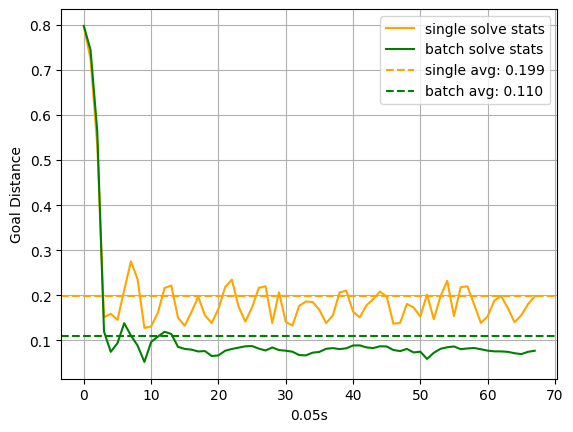

In [11]:
import matplotlib.pyplot as plt

# plot position error of mpc_stats_sample vs mpc_stats on same axis
fig, ax = plt.subplots()
ax.plot(mpc_stats['goal_distances'], label='single solve stats', color='orange')
ax.plot(mpc_stats_batch['goal_distances'], label='batch solve stats', color='g')

single_avg = np.mean(mpc_stats['goal_distances'])
batch_avg = np.mean(mpc_stats_batch['goal_distances'])
ax.axhline(y=single_avg, color='orange', linestyle='--', label=f'single avg: {single_avg:.3f}')
ax.axhline(y=batch_avg, color='g', linestyle='--', label=f'batch avg: {batch_avg:.3f}')

ax.set_xlabel('0.05s')
ax.set_ylabel('Goal Distance')
ax.legend()
ax.grid(True)
plt.show()

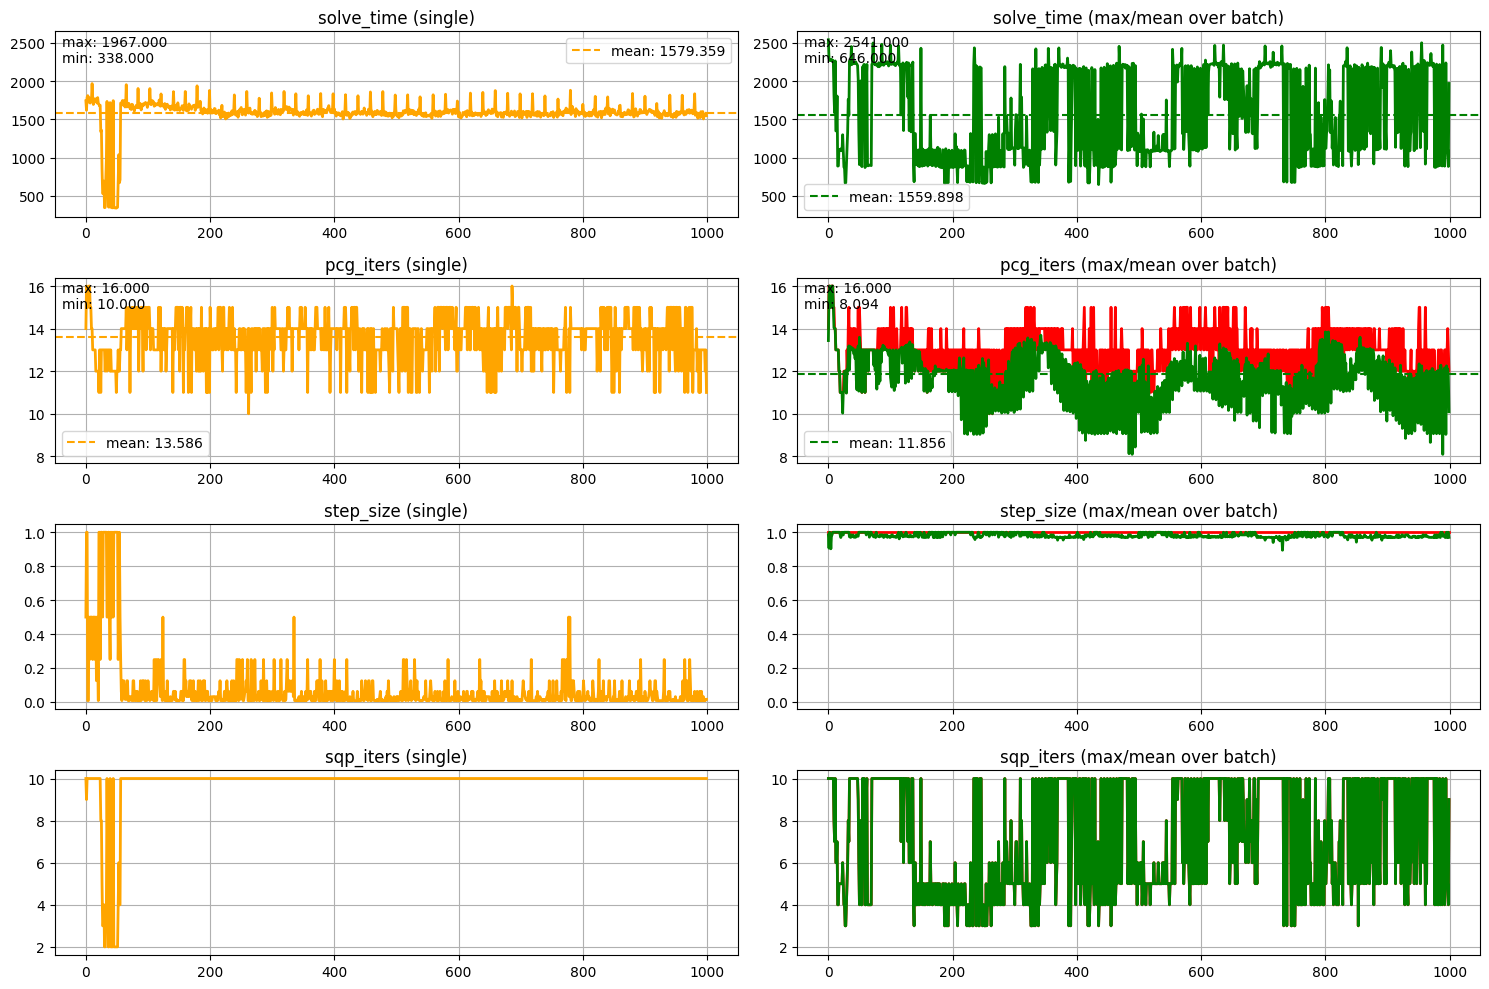

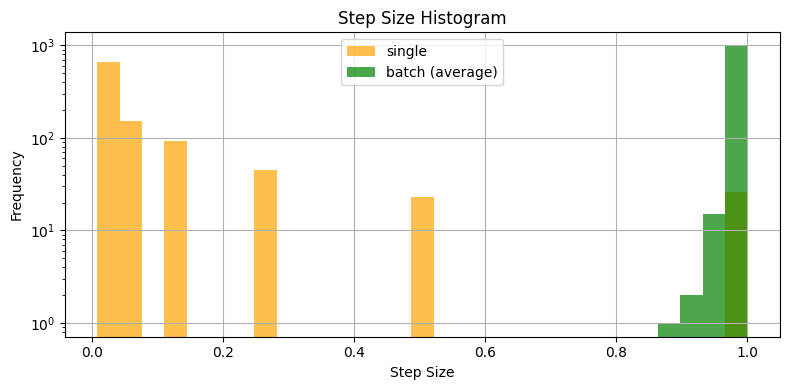

In [12]:
stats = mpc.solver.get_stats()
batch_stats = mpc_batch.solver.get_stats()

import matplotlib.pyplot as plt

fig, axs = plt.subplots(len(stats), 2, figsize=(15, 2.5*len(stats)))
if len(stats) == 1:
    axs = [axs]

step_size_values = None
batch_step_size_values = None

for i, (key, data) in enumerate(stats.items()):
    ax = axs[i][0]  # Use first column
    ax2 = axs[i][1]  # Use second column
    if isinstance(data, dict) and 'values' in data:
        values = np.array(data['values'][1:])
        batch_values = np.array(batch_stats[key]['values'][1:])
        values = np.maximum(values, 0.0)  # Replace negative values with 0.0
        batch_values = np.maximum(batch_values, 0.0)
            
        if key == 'sqp_iters' or key == 'pcg_iters':
            max_batch = np.max(batch_values, axis=1)
            batch_values = np.mean(batch_values, axis=1)
            ax2.plot(range(len(max_batch)), max_batch, label='', linewidth=2.0, color='r')
            
        if key == 'step_size':
            ax2.plot(range(len(np.max(batch_values, axis=1))), np.max(batch_values, axis=1), label='', linewidth=2.0, color='r')
            batch_values = np.mean(batch_values, axis=1)
            step_size_values = values
            batch_step_size_values = batch_values
            
        ax2.plot(range(len(batch_values)), batch_values, label='', linewidth=2.0, color='g')
        ax.plot(range(len(values)), values, label='', linewidth=2.0, color='orange')
        ax.set_title(f'{key} (single)')
        ax2.set_title(f'{key} (max/mean over batch)')
            
        y_min = min(np.min(values), np.min(batch_values))
        y_max = max(np.max(values), np.max(batch_values))
        y_range = y_max - y_min
        y_min -= 0.05 * y_range  # Add 5% padding
        y_max += 0.05 * y_range
        ax.set_ylim(y_min, y_max)
        ax2.set_ylim(y_min, y_max)
        
        
        if key == 'solve_time' or key == 'pcg_iters':
            ax.axhline(np.mean(values), color='orange', linestyle='--', label=f'mean: {np.mean(values):.3f}')
            ax2.axhline(np.mean(batch_values), color='g', linestyle='--', label=f'mean: {np.mean(batch_values):.3f}')
            ax.text(0.01, 0.98, f'max: {np.max(values):.3f}\nmin: {np.min(values):.3f}', 
                   transform=ax.transAxes, verticalalignment='top')
            ax2.text(0.01, 0.98, f'max: {np.max(batch_values):.3f}\nmin: {np.min(batch_values):.3f}',
                    transform=ax2.transAxes, verticalalignment='top')        
    ax.grid(True)
    ax2.grid(True)
    
    if i <= 1:  # Only show legend for first subplot
        ax.legend()
        ax2.legend()
        
plt.tight_layout()
plt.show()

# Plot histogram of step sizes (single solve only)
if step_size_values is not None:
    plt.figure(figsize=(8, 4))
    bins = np.linspace(np.min(step_size_values), np.max(step_size_values), 30)
    plt.hist(step_size_values, bins=bins, alpha=0.7, 
             label='single', color='orange')
    plt.hist(batch_step_size_values, bins=bins, alpha=0.7, 
             label='batch (average)', color='g')
    
    plt.yscale('log')  # Use logarithmic scale for y-axis

    plt.xlabel('Step Size')
    plt.ylabel('Frequency')
    plt.title('Step Size Histogram')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [13]:
# load two robot models
model1, visual_model1, collision_model1 = pin.buildModelsFromUrdf(urdf_path, model_dir)
model2, visual_model2, collision_model2 = pin.buildModelsFromUrdf(urdf_path, model_dir)

# single visualizer
viz = MeshcatVisualizer(model1, collision_model1, visual_model1)
viz.initViewer(open=True)
viz.loadViewerModel(rootNodeName="robot1", color=[1.0, 0.0, 0.0, 0.5])
viz_2 = MeshcatVisualizer(model1, collision_model1, visual_model1)
viz_2.initViewer(viz.viewer)
viz_2.loadViewerModel(rootNodeName="robot2", color=[0.0, 1.0, 0.0, 0.5])
for i in range(int(len(fig_8_traj)/6)):
    viz.viewer[f'point{i}'].set_object(
        g.Sphere(0.025), 
        g.MeshLambertMaterial(color=0xff0000))
    T = tf.translation_matrix(np.array(fig_8_traj[6*i:6*(i+1)][:3]))
    viz.viewer[f'point{i}'].set_transform(T)    
    
q_trajectory1, q_trajectory2 = q_trajectory, q_trajectory_batch

while True:
    viz.display(q_trajectory1[0]) 
    viz_2.display(q_trajectory2[0])
    
    q_trajectory1 = q_trajectory1[1:] 
    q_trajectory2 = q_trajectory2[1:] 
    
    time.sleep(0.01)  # display rate

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7008/static/


/home/alex/a2r/gato/GATO/.venv/lib/python3.10/site-packages/cmeel.prefix/lib/python3.10/site-packages/pinocchio/visualize/meshcat_visualizer.py:913: DeprecatedWarning: The 'color' argument is deprecated and will be removed in a future version of Pinocchio. Consider using 'collision_color' and 'visual_color' instead.
  warnings.warn(


KeyboardInterrupt: 